# F1 statistics & simulation

## Introduction

Credit:
The original version of this notebook was created by David Chevrier, Diggers.

More information: https://www.diggers-consulting.com/blog/articles/how-data-science-could-turn-felipe-massa-a-f1-world-champion

## Dataset
Data from https://ergast.com/mrd/db/#csv
F1 data from 1950 to 2019

## Initialization & creation of the atoti session

In [1]:
import atoti as tt
import numpy as np
import pandas as pd

session = tt.create_session()

Welcome to atoti 0.4.1!

By using this community edition, you agree with the license available at https://www.atoti.io/eula.
Browse the official documentation at https://docs.atoti.io.
Join the community at https://www.atoti.io/register.

You can hide this message by setting the ATOTI_HIDE_EULA_MESSAGE environment variable to True.


## Creation of the stores

In [2]:
drivers_df = pd.read_csv(
    "https://data.atoti.io/notebooks/formula-one/drivers.csv", encoding="latin-1"
)
drivers_df.rename(columns={"url": "driver_url"}, inplace=True)
drivers_df.rename(columns={"nationality": "driver_nationality"}, inplace=True)

drivers_store = session.read_pandas(
    drivers_df, keys=["driverId"], store_name="F1 drivers"
)

In [3]:
races_df = pd.read_csv(
    "https://data.atoti.io/notebooks/formula-one/races.csv", encoding="latin-1"
)
races_df.rename(columns={"url": "race_url"}, inplace=True)
races_df.rename(columns={"name": "race_name"}, inplace=True)

races_store = session.read_pandas(
    races_df, keys=["raceId"], store_name="F1 races", types={"year": tt.types.STRING}
)

In [4]:
constructors_df = pd.read_csv(
    "https://data.atoti.io/notebooks/formula-one/constructors.csv", encoding="latin-1"
)
constructors_df.rename(columns={"url": "constructor_url"}, inplace=True)
constructors_df.rename(columns={"name": "constructor_name"}, inplace=True)
constructors_df.rename(columns={"nationality": "constructor_nationality"}, inplace=True)

constructors_store = session.read_pandas(
    constructors_df, keys=["constructorId"], store_name="F1 constructors",
)

In [5]:
results_df = pd.read_csv("https://data.atoti.io/notebooks/formula-one/results.csv")
results_df.loc[results_df['fastestLapSpeed'] == '\\N', 'fastestLapSpeed'] = None
results_df.loc[results_df['position'] == '\\N', 'position'] = None

resultsTypes = {
    "fastestLapSpeed": tt.types.DOUBLE,
    "points": tt.types.DOUBLE,
    "position": tt.types.INT,
    "resultId": tt.types.STRING,
}

results_store = session.read_pandas(
    results_df, keys=["resultId"], store_name="F1 results", types=resultsTypes,
)

The store has been sampled because there are more than 10000 lines in the files to load. Call Session.load_all_data() to trigger the full load of the data.


In [6]:
results_store.join(drivers_store, mapping={"driverId": "driverId"})
results_store.join(races_store, mapping={"raceId": "raceId"})
results_store.join(constructors_store, mapping={"constructorId": "constructorId"})

## Cube

In [7]:
f1cube = session.create_cube(results_store, "F1Cube")

In [8]:
# We can now load all the data so that visualizations operate on the entire dataset.
# NB: as a best practice, to optimize speed while exploring your data, we recommend keeping the default sampling mode enabled.
#     Once the model is ready, as it is the case in this notebook, you may call session.load_all_data() after creating the cube.
session.load_all_data()

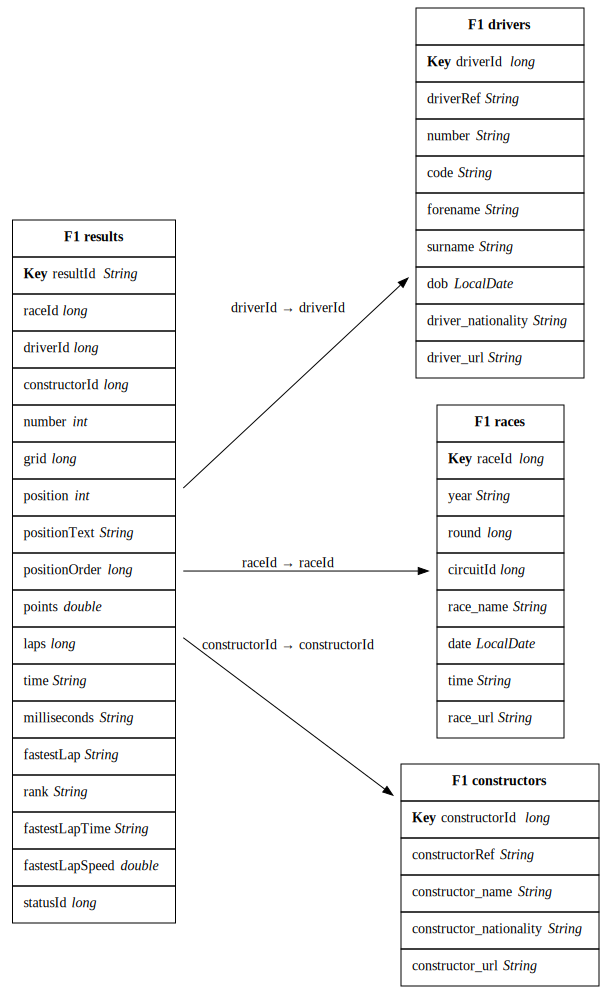

In [9]:
f1cube.schema

In [10]:
lvl = f1cube.levels
m = f1cube.measures
h = f1cube.hierarchies

## Analysis

### Driver with the most races

Barichello has cumulated more than 326 races over his career!

In [12]:
f1cube.visualize("Total number of races per driver")

Install and enable the atoti JupyterLab extension to see this widget.

### Fastest drivers



In [50]:
# Update when https://github.com/atoti/atoti/issues/77 is fixed
m["fastestLapSpeed.VALUE"] = results_store["fastestLapSpeed"]
m["fastestLapSpeed.MIN"] = tt.agg.min(tt.where(m["fastestLapSpeed.VALUE"] > 0, results_store["fastestLapSpeed"], None))
m["Fastest driver"] = tt.agg.min_member(m["fastestLapSpeed.MIN"], lvl["driverRef"])
m["Fastest year"] = tt.agg.min_member(m["fastestLapSpeed.MIN"], lvl["year"])

In [52]:
f1cube.visualize()

Install and enable the atoti JupyterLab extension to see this widget.

### Top driver and constructors

Let's create some measures to return the driver and constructor with the most points.

In [53]:
m["Score"] = m["points.SUM"]
m["Top driver"] = tt.agg.max_member(m["Score"], lvl["driverRef"])
m["Top constructor"] = tt.agg.max_member(m["Score"], lvl["constructor_name"])

In [17]:
f1cube.visualize("Top driver by year")

Install and enable the atoti JupyterLab extension to see this widget.

In [19]:
f1cube.visualize("Top constructor by year")

Install and enable the atoti JupyterLab extension to see this widget.

Lewis Hamilton and it's team Mercedes have been dominating the championship for almost the last 6 years.

Let's compare driver's scores:

In [21]:
f1cube.visualize("Score per drivers")

Install and enable the atoti JupyterLab extension to see this widget.

Hamilton is the driver with the most points ever. However, it's unfair to compare points accross seasons since the scoring systems are not constant and most recent seasons award more points to drivers. This explains why pilots like Hamilton and Vettel have much more points than Schumacher while having ran and scored less races.

### Different scoring systems

Scoring rules for Formula One have [changed over time](https://en.wikipedia.org/wiki/List_of_Formula_One_World_Championship_points_scoring_systems). To make a fair comparison, let's normalize the points across all years by applying a constant scoring across all seasons.

First, we'll determine the maximum position across all seasons:

In [22]:
m["position.MAX"] = tt.agg.max(results_store["position"])

In [23]:
maxPositionDf = f1cube.query(m["position.MAX"])
maxPositionDf

,position.MAX
0,33


This means that there has never been more than 33 drivers in one race. We'll use that information to create a data frame representing the different points awarded by positions across all scoring system:

In [24]:
# index = scoring systen
scoring_systems = [
    "Scoring 1950 to 1959",
    "Scoring 1960",
    "Scoring 1961 to 1990",
    "Scoring 1991 to 2002",
    "Scoring 2003 to 2009",
    "Scoring 2010 to 2013",
    "Scoring 2014",
    "Scoring 2015 to 2018",
    "Scoring 2019",
]
scoring_positions = np.arange(1, maxPositionDf["position.MAX"][0] + 1)

# a column for each position
# values = number of points scored for this year's race position
dfscoring = pd.DataFrame(0, index=scoring_systems, columns=scoring_positions,)

In [25]:
dfscoring.loc["Scoring 1950 to 1959"][1, 2, 3, 4, 5] = [8, 6, 4, 3, 2]
dfscoring.loc["Scoring 1960"][1, 2, 3, 4, 5, 6] = [8, 6, 4, 3, 2, 1]
dfscoring.loc["Scoring 1961 to 1990"][1, 2, 3, 4, 5, 6] = [9, 6, 4, 3, 2, 1]
dfscoring.loc["Scoring 1991 to 2002"][1, 2, 3, 4, 5, 6] = [10, 6, 4, 3, 2, 1]
dfscoring.loc["Scoring 2003 to 2009"][1, 2, 3, 4, 5, 6, 7, 8] = [
    10,
    8,
    6,
    5,
    4,
    3,
    2,
    1,
]
dfscoring.loc["Scoring 2010 to 2013"][1, 2, 3, 4, 5, 6, 7, 8, 9, 10] = [
    25,
    18,
    15,
    12,
    10,
    8,
    6,
    4,
    2,
    1,
]
dfscoring.loc["Scoring 2014"][1, 2, 3, 4, 5, 6, 7, 8, 9, 10] = [
    25,
    18,
    15,
    12,
    10,
    8,
    6,
    4,
    2,
    1,
]
dfscoring.loc["Scoring 2015 to 2018"] = dfscoring.loc["Scoring 2010 to 2013"]
dfscoring.loc["Scoring 2019"] = dfscoring.loc["Scoring 2010 to 2013"]

dfscoring

,1,2,3,4,5,6,7,8,9,10,...,24,25,26,27,28,29,30,31,32,33
Scoring 1950 to 1959,8,6,4,3,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Scoring 1960,8,6,4,3,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Scoring 1961 to 1990,9,6,4,3,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Scoring 1991 to 2002,10,6,4,3,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Scoring 2003 to 2009,10,8,6,5,4,3,2,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Scoring 2010 to 2013,25,18,15,12,10,8,6,4,2,1,...,0,0,0,0,0,0,0,0,0,0
Scoring 2014,25,18,15,12,10,8,6,4,2,1,...,0,0,0,0,0,0,0,0,0,0
Scoring 2015 to 2018,25,18,15,12,10,8,6,4,2,1,...,0,0,0,0,0,0,0,0,0,0
Scoring 2019,25,18,15,12,10,8,6,4,2,1,...,0,0,0,0,0,0,0,0,0,0


### Score implementation

In [ ]:
m["Best results"] = 1
m["Score"] = m["points.SUM"]

### Simulations

Using the dataframe created before, we'll setup one simulation per scoring system:

In [26]:
# Creation of simulation
pointssystem_sim = f1cube.setup_simulation(
    "pointssystem_sim",
    levels=[lvl["positionText"], lvl["resultId"]],
    replace=[m["points.SUM"]],
    base_scenario="Base",
)

In [27]:
# Creation of the different scenarios
scoring_scenario = {}
for scoring_name in scoring_systems:
    scoring_scenario[scoring_name] = pointssystem_sim.scenarios[scoring_name]

In [28]:
# Feed of the different scenarios with points from related scoring systems
for scoring_name in scoring_systems:
    for i in scoring_positions:
        x = float(dfscoring.loc[scoring_name][i])
        scoring_scenario[scoring_name] += (str(i), None, x)

In [29]:
# Example of scoring scenario
scoring_scenario["Scoring 2019"].head(10)

,,pointssystem_sim_points.SUM_replace,Priority
positionText,resultId,,
1.0,NaN,25.0,0.0
2.0,NaN,18.0,0.0
3.0,NaN,15.0,0.0
4.0,NaN,12.0,0.0
5.0,NaN,10.0,0.0
6.0,NaN,8.0,0.0
7.0,NaN,6.0,0.0
8.0,NaN,4.0,0.0
9.0,NaN,2.0,0.0


In [31]:
f1cube.visualize("Top driver by year across scenarios")

Install and enable the atoti JupyterLab extension to see this widget.

In [33]:
# Apply conditional formatting via MDX
#  Member [Measures].[Top driver (1)] AS [Measures].[Top driver], FORE_COLOR = iif(
#   [Measures].[Top driver] <> (
#     [Measures].[Top driver],
#     [Measure Simulations].[pointssystem_sim].[pointssystem_sim].[Base]
#   ),
#   "red",
#   NULL
# )
f1cube.visualize("Champion comparison")

Install and enable the atoti JupyterLab extension to see this widget.

## TODO

In [35]:
f1cube.visualize("Total points per constructors")

Install and enable the atoti JupyterLab extension to see this widget.

In [37]:
f1cube.visualize("Top driver by race")

Install and enable the atoti JupyterLab extension to see this widget.

In [39]:
f1cube.visualize("Top constructor by race")

Install and enable the atoti JupyterLab extension to see this widget.

### Showing the differences for the race result of a famous GP, Brazil 2008
Where we see how the 1991-2002 scoring systems makes a big difference between chamionship rivals Massa & Hamilton
See race summary here: https://www.youtube.com/watch?v=XHSeGou-pCI ;)

In [41]:
f1cube.visualize("Base vs. Simulation - Brazil 2008")

Install and enable the atoti JupyterLab extension to see this widget.

### Showing the differences for the 2008 world championship result
Would Felipe Massa have become world champ in 2008 with the 1991-2002 scoring system?? YES!

In [43]:
f1cube.visualize("Base vs. Simulation System 1991 to 2002 - 2008 Championship")

Install and enable the atoti JupyterLab extension to see this widget.

In [45]:
f1cube.visualize("Base vs. Simulation - 2008 Championship table")

Install and enable the atoti JupyterLab extension to see this widget.